# Capstone Project - The Battle of the Neighborhoods (Week 2)
### Applied Data Science Capstone by IBM/Coursera
#### Tenzin Kunsang, September 2020

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology & Results](#methodology)

## Introduction: Business Problem <a name="introduction"></a>

In this notebook, I looked into neighborhoods in **Minneapolis** and clustered them based on Zillow's median Home Value Index (HVI), estimation of change in the HVI by month, quarter, year, and venues in each neighborhood. I also grouped **homes in Minneapolis** into clusters using home details such as number of bedrooms, bathrooms, year built, home sale price, etc. 

For this, I accounted for the homes' nearby venues as factors for clustering. The goal for the usage of K-means clustering algorithm to cluster Minneapolis on the level of 
<ul>
  <li>neighborhoods</li>
  <li>homes</li>
</ul>
is to analyze how location, home details, and neighborhood comps play into people's decision in buying home. 

Therefore, this analysis can be reproduced for buyers looking for home for their family, for property investors, realtors, agents, and data scientists looking for ideas to use their real estate data. 

## Data <a name="data"></a>

Most of the data on this notebook are dynamically produced and scraped. However, for ease, I have saved these data after scraping in order to not repeat some of the process that takes hours and hours. 

Before I extract any data, I wanted to get the best and most updated list of neighborhoods in Minneapolis. Therefore, I scraped the list from wikipedia page:
https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Minneapolis

Current average home values in each neighborhood is important to consider when looking at homes. For the home value index (HVI) in Minneapolis, the scraped dataset from Zillow didn’t contain enough information. Therefore I manually downloaded it from the following page:
https://www.zillow.com/minneapolis-mn/home-values/

Sales prices of similar homes in neighborhoods that have been sold recently gives a good estimation of what price range the home of your choice might land in. Some other important features when buying a home are the home size, age and condition, and neighborhood comps. I scraped these data from Zillow (https://www.zillow.com/)using a platform called Apify. Unfortunately this API didn’t readily return neighborhood names so I manually searched for homes in each neighborhood in Minneapolis separately on the platform.
https://apify.com/

Many families consider the quality of local schools, employment opportunities, proximity to shopping etc. before buying a home. I used Foursquare API to get a sense of the neighborhood locations by looking at venues closeby. Moreover, I used this API to get the nearby venues for each home to get a better idea of how homes in the same neighborhood differ based on the distance from nearby venues. 
https://developer.foursquare.com/

In order to create choropleth maps, I found a geojson file of neighborhoods of Minneapolis on Github, which I later edited and matched with neighborhood names found on Wikipedia: https://github.com/blackmad/neighborhoods/blob/master/minneapolis.geojson  

## Methodology & Results <a name="methodology"></a>

## Part A 
### Neighborhoods in Minneapolis

#### Here are the main parameters in this section
<ul>
    <li> Zillow's Home Value Index (zHVI) 
    <li> Month on Month				
    <li> Quarter on Quarter
    <li> Year on Year
    <li> Five Year Annualized
    <li> Ten Year Annualized
    <li> Venues in each neighborhood
</ul>

#### Importing all the libraries that will be used in this program.

In [452]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import numpy as np

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes #uncomment if geopy has not been installed 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes #uncomment if folium has not been installed 
import folium # map rendering library

#!pip install BeautifulSoup4
from urllib.request import urlopen
from bs4 import BeautifulSoup as bs
import ssl
import csv

import urllib.parse
import urllib.error
import ast
import os
from urllib.request import Request, urlopen

#to extract the csv file of latitude and longitude 
import io 

#to deal with regex - regular expressions
import re

#for some plots
import matplotlib.pyplot as plt

print('Libraries imported.')

Libraries imported.


#### Scrape neighborhoods in Minneapolis from wikipedia using BeautifulSoup

In [453]:
url = requests.get("https://en.wikipedia.org/wiki/Category:Neighborhoods_in_Minneapolis")

soup = bs(url.text, "html.parser")

neighborhood = []

for link in soup.find_all("a"):
    neighbor = link.get("title")
    neighborhood.append(neighbor)

neighborhood = list(filter(None.__ne__, neighborhood)) #remove Nonetype in list of neighborhoods
neighborhood = pd.DataFrame(neighborhood)

#cleanup the neighborhood dataframe 
neighborhoodDict = {"neighborhood": []}
for row, neighbor in neighborhood.iterrows(): 
    if 'Minneapolis' in neighbor[0]:
        neighborhoodDict["neighborhood"].append(neighbor[0])

neighborhoodMinn = pd.DataFrame(neighborhoodDict)

#remove rows that are not neighborhoods
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[0, 1, 2, 3, 91, 92]]).reset_index(drop=True)

#cleanup some names of neighborhood in order to locate it later for latitude and longitude

exp = re.compile(r' \(neighborhood\)')
neighborhoodMinn['neighborhood'] = [exp.sub('', x) for x in neighborhoodMinn['neighborhood']]

#Mill District results in Nonetype latitude and longitude values so drop its row
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[51]]).reset_index(drop=True)

#remove Ventura Village because it's located outside Minneapolis - according to FourSquare API
neighborhoodMinn = neighborhoodMinn.drop(neighborhoodMinn.index[[76]]).reset_index(drop=True)

#Nicollet Island- East Bank, Minneapolis' returns a NoneType error, so therefore changed it to Nicollet Island
neighborhoodMinn['neighborhood'] = neighborhoodMinn['neighborhood'].replace(['Nicollet Island/East Bank, Minneapolis'],'Nicollet Island, Minneapolis')

neighborhoodMinn.head()

,neighborhood
0,"Armatage, Minneapolis"
1,"Audubon Park, Minneapolis"
2,"Bancroft, Minneapolis"
3,"Beltrami, Minneapolis"
4,"Bottineau, Minneapolis"


#### Get the latitude and longitude of all the neighborhoods 

In [454]:
# DO NOT RUN THIS CODE CHUNK UNLESS NECESSARY

# this code block takes ~ 45 seconds on my machine due to having to locate latitude and longitude for 85 neighborhoods

latitude = []
longitude = []

geolocator = Nominatim(user_agent="minneapolis_explorer")
for row, neighbor in neighborhoodMinn.iterrows(): 
    location = geolocator.geocode(neighbor[0])
    latitude.append(location.latitude)
    longitude.append(location.longitude)

neighborhoodMinn['latitude'] = latitude
neighborhoodMinn['longitude'] = longitude
neighborhoodMinn.head()

,neighborhood,latitude,longitude
0,"Armatage, Minneapolis",44.897236,-93.310342
1,"Audubon Park, Minneapolis",45.018883,-93.236355
2,"Bancroft, Minneapolis",44.930570,-93.254929
3,"Beltrami, Minneapolis",44.995352,-93.242513
4,"Bottineau, Minneapolis",45.010566,-93.269304


#### Visualize the neighborhoods in Minneapolis using Folium

In [456]:
address = 'Minneapolis, Minnesota'
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Minneapolis are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Minneapolis are 44.9772995, -93.2654692.


In [457]:
# create map of Minneaplis using latitude and longitude values by neighborhood
map_minn_neighborhood = folium.Map(location = [latitude, longitude], zoom_start = 12)

# add markers to map
for lat, lng, neighborhood in zip(neighborhoodMinn['latitude'], neighborhoodMinn['longitude'], neighborhoodMinn['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_minn_neighborhood)  
    
map_minn_neighborhood

#### Downloaded Minneapolis home values from Zillow in the folder. Read the data

In [458]:
neighborhood_df = pd.read_csv('neighborhoodData.csv')
neighborhood_df.head()  

,"Minneapolis, MN - All Homes",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


#### Cleanup data

In [459]:
header_row = 1
neighborhood_df.columns = neighborhood_df.iloc[header_row]
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Statistic,NaN,NaN,Zillow Home Value Index,NaN,NaN,NaN,NaN,NaN
1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
2,Minneapolis,city,All Homes,"$291,500",0.30%,0.90%,3.30%,6.30%,3.90%
3,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
4,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%


In [460]:
neighborhood_df = neighborhood_df.drop(neighborhood_df.index[[0, 1, 2]]).reset_index(drop=True)
neighborhood_df.head()

1,Region Name,Region Type,Type,Current,Month Over Month,Quarter Over Quarter,Year Over Year,5 Year Annualized,10 Year Annualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [461]:
neighborhood_df.rename(columns = {neighborhood_df.columns[0]: 'neighborhood', neighborhood_df.columns[3]: 'zestimatedHVI', neighborhood_df.columns[4]: 'MoM', neighborhood_df.columns[5]: 'QoQ', neighborhood_df.columns[6]: 'YoY', neighborhood_df.columns[7]: 'fiveYearAnnualized', neighborhood_df.columns[8]: 'tenYearAnnualized'}, inplace = True)
neighborhood_df.head()

1,neighborhood,Region Type,Type,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,neighborhood,All Homes,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,neighborhood,All Homes,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,neighborhood,All Homes,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,neighborhood,All Homes,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,neighborhood,All Homes,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [462]:
neighborhood_df.drop(neighborhood_df.columns[[1, 2]], axis = 1, inplace = True)
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,Armatage,"$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,Audubon Park,"$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,Bancroft,"$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,Beltrami,"$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,Bottineau,"$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [463]:
neighborhood_df['neighborhood'] = neighborhood_df['neighborhood'].astype(str) + ', Minneapolis'
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis","$360,400",0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis","$289,500",0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis","$275,200",0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis","$256,000",0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis","$282,100",0.50%,1.50%,6.10%,8.90%,5.40%


In [464]:
exp = re.compile(r'[$,]')
neighborhood_df['zestimatedHVI'] = [exp.sub('', x) for x in neighborhood_df['zestimatedHVI']]
neighborhood_df.head()


1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20%,0.50%,2.50%,5.10%,4.20%
1,"Audubon Park, Minneapolis",289500,0.40%,1.00%,6.20%,7.40%,4.50%
2,"Bancroft, Minneapolis",275200,0.20%,0.40%,0.90%,7.10%,4.40%
3,"Beltrami, Minneapolis",256000,0.20%,0.50%,2.20%,7.10%,4.00%
4,"Bottineau, Minneapolis",282100,0.50%,1.50%,6.10%,8.90%,5.40%


In [465]:
exp = re.compile(r'%')
neighborhood_df['MoM'] = [exp.sub('', x) for x in neighborhood_df['MoM']]
neighborhood_df['QoQ'] = [exp.sub('', x) for x in neighborhood_df['QoQ']]
neighborhood_df['YoY'] = [exp.sub('', x) for x in neighborhood_df['YoY']]
neighborhood_df['fiveYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['fiveYearAnnualized']]
neighborhood_df['tenYearAnnualized'] = [exp.sub('', x) for x in neighborhood_df['tenYearAnnualized']]

neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.20,0.50,2.50,5.10,4.20
1,"Audubon Park, Minneapolis",289500,0.40,1.00,6.20,7.40,4.50
2,"Bancroft, Minneapolis",275200,0.20,0.40,0.90,7.10,4.40
3,"Beltrami, Minneapolis",256000,0.20,0.50,2.20,7.10,4.00
4,"Bottineau, Minneapolis",282100,0.50,1.50,6.10,8.90,5.40


In [466]:
neighborhood_df.dtypes

1
neighborhood          object
zestimatedHVI         object
MoM                   object
QoQ                   object
YoY                   object
fiveYearAnnualized    object
tenYearAnnualized     object
dtype: object

In [467]:
neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]] = neighborhood_df[["zestimatedHVI", "MoM", "QoQ", "YoY", "fiveYearAnnualized", "tenYearAnnualized"]].apply(pd.to_numeric, errors = 'coerce')
neighborhood_df.dtypes

1
neighborhood           object
zestimatedHVI           int64
MoM                   float64
QoQ                   float64
YoY                   float64
fiveYearAnnualized    float64
tenYearAnnualized     float64
dtype: object

#### Final dataset of Minneapolis home value by neighborhood

In [468]:
neighborhood_df.head()

1,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2
1,"Audubon Park, Minneapolis",289500,0.4,1.0,6.2,7.4,4.5
2,"Bancroft, Minneapolis",275200,0.2,0.4,0.9,7.1,4.4
3,"Beltrami, Minneapolis",256000,0.2,0.5,2.2,7.1,4.0
4,"Bottineau, Minneapolis",282100,0.5,1.5,6.1,8.9,5.4


#### Preparation to get the venues of the neighborhoods using FourSquare API

In [469]:
CLIENT_ID = '---' # your Foursquare ID
CLIENT_SECRET = '---' # your Foursquare Secret
VERSION = '---'
LIMIT = 30

In [471]:
#function that takes neighborhood name, latitude, longitude as parameters and returns venues within 500m radius of the neighborhood

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Get nearby venues of all the neighborhoods

In [494]:
#DON'T LOAD THIS UNLESS COMPLETELY NECESSARY

minneapolis_venues = getNearbyVenues(names=neighborhoodMinn['neighborhood'],
                                   latitudes=neighborhoodMinn['latitude'],
                                   longitudes=neighborhoodMinn['longitude']
                                  )

print(minneapolis_venues.shape)

Armatage, Minneapolis
Audubon Park, Minneapolis
Bancroft, Minneapolis
Beltrami, Minneapolis
Bottineau, Minneapolis
Bryant, Minneapolis
Bryn Mawr, Minneapolis
Cedar-Isles-Dean, Minneapolis
Cedar-Riverside, Minneapolis
Central, Minneapolis
Cleveland, Minneapolis
Columbia Park, Minneapolis
Como, Minneapolis
Cooper, Minneapolis
Corcoran, Minneapolis
Diamond Lake, Minneapolis
Downtown East, Minneapolis
Downtown West, Minneapolis
East Calhoun, Minneapolis
East Harriet, Minneapolis
East Isles, Minneapolis
East Phillips, Minneapolis
Elliot Park, Minneapolis
Ericsson, Minneapolis
Field, Minneapolis
Folwell, Minneapolis
Fulton, Minneapolis
Hale, Minneapolis
Harrison, Minneapolis
Hawthorne, Minneapolis
Hiawatha, Minneapolis
Holland, Minneapolis
Howe, Minneapolis
Jordan, Minneapolis
Keewaydin, Minneapolis
Kenny, Minneapolis
Kenwood, Minneapolis
King Field, Minneapolis
Lind-Bohanon, Minneapolis
Linden Hills, Minneapolis
Logan Park, Minneapolis
Longfellow, Minneapolis
Lowry Hill East, Minneapolis
Lo

In [495]:
#view the resulting dataset of venues
minneapolis_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Armatage, Minneapolis",44.897236,-93.310342,Armatage Park,44.899459,-93.310883,Park
1,"Armatage, Minneapolis",44.897236,-93.310342,Domino's Pizza,44.894770,-93.308208,Pizza Place
2,"Armatage, Minneapolis",44.897236,-93.310342,"Wagner Greenhouses, Inc.",44.892827,-93.309378,Flower Shop
3,"Armatage, Minneapolis",44.897236,-93.310342,Minnehaha Creek,44.897722,-93.311425,Trail
4,"Armatage, Minneapolis",44.897236,-93.310342,Armatage Skate Park,44.899742,-93.310570,Skate Park


In [496]:
#how many venues were returned for each neighborhood
#The neighborhood names are further cleaned up to be used with a geo json file for map later

neighborhoodVenues = minneapolis_venues.groupby('Neighborhood').count()
neighborhoodVenues.drop(neighborhoodVenues.columns[[1, 2, 3, 4, 5]], axis = 1, inplace = True)
neighborhoodVenues.reset_index(level=0, inplace=True)
neighborhoodVenues.rename(columns = {'Neighborhood': 'neighborhood', 'Neighborhood Latitude': 'count'}, inplace = True)
exp = re.compile(r', Minneapolis')
neighborhoodVenues['neighborhood'] = [exp.sub('', x) for x in neighborhoodVenues['neighborhood']]
neighborhoodVenues.head()

,neighborhood,count
0,Armatage,8
1,Audubon Park,20
2,Bancroft,5
3,Beltrami,12
4,Bottineau,19


In [497]:
#how many unique categories can be curated from all the returned values

print('There are {} uniques categories.'.format(len(minneapolis_venues['Venue Category'].unique())))

There are 220 uniques categories.


#### Use one hot encoding to put the unique categories in columns

In [498]:
minneapolis_onehot = pd.get_dummies(minneapolis_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
minneapolis_onehot['Neighborhood'] = minneapolis_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [minneapolis_onehot.columns[-1]] + list(minneapolis_onehot.columns[:-1])
minneapolis_onehot = minneapolis_onehot[fixed_columns]

minneapolis_onehot.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,"Armatage, Minneapolis",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [499]:
#group rows by neighborhood, take the mean of the frequency of occurrence of each category
 
minneapolis_grouped = minneapolis_onehot.groupby('Neighborhood').mean().reset_index()
minneapolis_grouped.head()

,Neighborhood,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [500]:
minneapolis_grouped.shape

(85, 221)

#### Print each neighborhood along with the top 5 most common venues

In [501]:
num_top_venues = 5

for hood in minneapolis_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = minneapolis_grouped[minneapolis_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Armatage, Minneapolis----
               venue  freq
0              Trail  0.12
1  Convenience Store  0.12
2               Food  0.12
3     Shipping Store  0.12
4        Pizza Place  0.12


----Audubon Park, Minneapolis----
                venue  freq
0            Pharmacy  0.10
1   Convenience Store  0.10
2      Cosmetics Shop  0.10
3  Chinese Restaurant  0.05
4    Department Store  0.05


----Bancroft, Minneapolis----
                  venue  freq
0           Yoga Studio   0.2
1  Caribbean Restaurant   0.2
2         Garden Center   0.2
3        Discount Store   0.2
4        Ice Cream Shop   0.2


----Beltrami, Minneapolis----
                venue  freq
0         Bus Station  0.08
1           Gift Shop  0.08
2      Clothing Store  0.08
3          Playground  0.08
4  Chinese Restaurant  0.08


----Bottineau, Minneapolis----
               venue  freq
0                Bar  0.11
1               Park  0.11
2   Theme Restaurant  0.11
3  German Restaurant  0.05
4       Liquor Store  0.

In [502]:
#function to sort the venues in descending order

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [503]:
#create the new dataframe and display the top 10 venues for each neighborhood

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = minneapolis_grouped['Neighborhood']

for ind in np.arange(minneapolis_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(minneapolis_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",Pizza Place,Shipping Store,Skate Park,Trail,Park,Flower Shop,Convenience Store,Food,Flea Market,Fishing Spot
1,"Audubon Park, Minneapolis",Pharmacy,Cosmetics Shop,Convenience Store,Hotel Bar,Flea Market,Chinese Restaurant,Coffee Shop,Park,Movie Theater,Bakery
2,"Bancroft, Minneapolis",Yoga Studio,Ice Cream Shop,Garden Center,Discount Store,Caribbean Restaurant,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Food
3,"Beltrami, Minneapolis",Coffee Shop,Asian Restaurant,Brewery,Café,Gay Bar,Chinese Restaurant,Clothing Store,Gift Shop,Liquor Store,Bus Station
4,"Bottineau, Minneapolis",Theme Restaurant,Bar,Park,Harbor / Marina,German Restaurant,Liquor Store,Bus Station,BBQ Joint,Coffee Shop,Gym


In [504]:
#merge the dataset containing zestimate values etc. with the dataset containing location venues 
minneapolis_grouped = neighborhood_df.join(minneapolis_grouped.set_index('Neighborhood'), on='neighborhood') 
minneapolis_grouped.head()

,neighborhood,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",360400,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0

In [505]:
#merge the dataset further by including the latitude and longitude of the neighborhoods and dropping the rows with NA 
minneapolis_grouped = neighborhoodMinn.join(minneapolis_grouped.set_index('neighborhood'), on='neighborhood')
minneapolis_grouped = minneapolis_grouped.dropna()
minneapolis_grouped.head()

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.

#### Create a new dataset that contains only the parameters that will be used to cluster the neighborhoods

In [506]:
minneapolis_grouped_clustering = minneapolis_grouped.drop(minneapolis_grouped.columns[[0,1,2]], 1)
minneapolis_grouped_clustering.head()

,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
0,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.125,0.000000,0.0,0.0,0.0

#### Prep for Clustering the neighborhoods. Find the optimal value for k using Elbow method

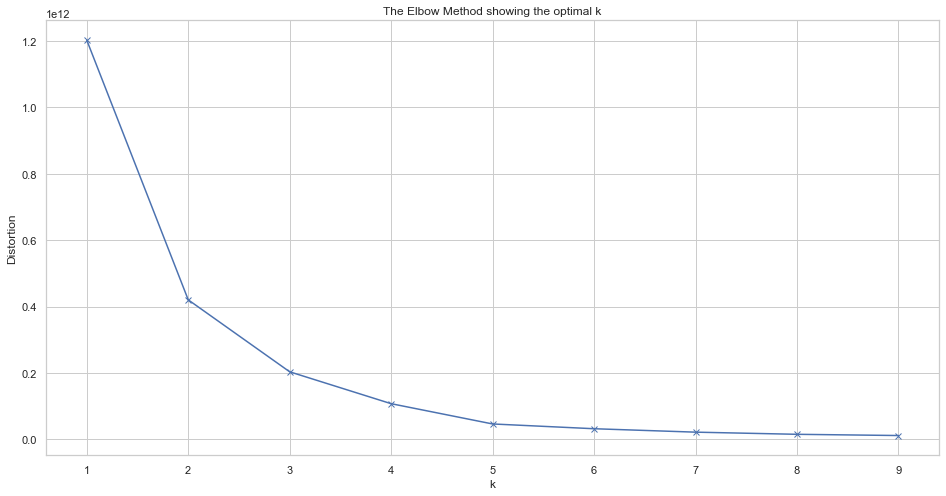

In [507]:
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(minneapolis_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### From the elbow method, set number of clusters to 5.

In [508]:
np.random.seed(0)
# from elbow method, set number of clusters to 5
kclusters = 5

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(minneapolis_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([3, 1, 1, 1, 1, 1, 3, 0, 4, 1], dtype=int32)

In [509]:
labels = kmeans.labels_
print(labels)

[3 1 1 1 1 1 3 0 4 1 4 1 1 1 3 0 1 0 3 3 4 1 1 4 0 3 4 1 1 1 4 1 3 2 4 1 1
 3 0 1 0 1 4 1 1 3 1 4 1 1 1 1 4 1 4 1 4 1 4 1 1 4 1 1]


In [510]:
# add clustering labels
minneapolis_grouped["Labels"] = labels
minneapolis_grouped.head(5)

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Labels
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00

In [515]:
#merge the minneapolis_grouped dataset with the top 10 venues of each neighborhood
minneapolis_grouped = minneapolis_grouped.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='neighborhood') 
minneapolis_grouped.head()

,neighborhood,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio,Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",44.897236,-93.310342,360400.0,0.2,0.5,2.5,5.1,4.2,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.125,0.125,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.

In [516]:
minneapolis_grouped.to_csv('neighborhoodLabeled.csv')

In [618]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles='CartoDB dark_matter', zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(minneapolis_grouped['latitude'], minneapolis_grouped['longitude'], minneapolis_grouped['neighborhood'], minneapolis_grouped['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<ul>
<li>cluster 0: red
<li>cluster 1: purple
<li>cluster 2: blue (only one neighborhood: Kenwood, Minneapolis)
<li>cluster 3: turquoise (middle left)
<li>cluster 4: light green (upper left and center)

</ul>


#### Examine clusters

In [523]:
#CLUSTER 1

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 0, minneapolis_grouped.columns[[0, 3, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,"Cedar-Isles-Dean, Minneapolis",534100.0,Tourist Information Center,Bridge,Beach,Sporting Goods Shop,American Restaurant,Speakeasy,Gym / Fitness Center,Flea Market,Fish & Chips Shop,Fishing Spot
16,"Downtown East, Minneapolis",554800.0,Coffee Shop,Japanese Restaurant,Bar,Pub,Hotel,Music Venue,Seafood Restaurant,Sandwich Place,Public Art,Park
18,"East Calhoun, Minneapolis",534000.0,Scenic Lookout,Cosmetics Shop,Bakery,Beach,Ice Cream Shop,Food Truck,Food Court,Food & Drink Shop,Farmers Market,Food
26,"Fulton, Minneapolis",515500.0,Antique Shop,Coffee Shop,Pet Store,Gourmet Shop,Thrift / Vintage Store,Shipping Store,Pizza Place,Art Gallery,Farmers Market,Fast Food Restaurant
43,"Lowry Hill, Minneapolis",661900.0,Asian Restaurant,Acupuncturist,Restaurant,Steakhouse,American Restaurant,Ice Cream Shop,Liquor Store,Bar,Gift Shop,Mexican Restaurant
45,"Lynnhurst, Minneapolis",598400.0,Art Gallery,Burger Joint,Gift Shop,Coffee Shop,Grocery Store,English Restaurant,Trail,Juice Bar,Pet Store,Breakfast Spot


In [524]:
#CLUSTER 2

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 1, minneapolis_grouped.columns[[0, 3, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,"Audubon Park, Minneapolis",289500.0,Pharmacy,Cosmetics Shop,Convenience Store,Hotel Bar,Flea Market,Chinese Restaurant,Coffee Shop,Park,Movie Theater,Bakery
2,"Bancroft, Minneapolis",275200.0,Yoga Studio,Ice Cream Shop,Garden Center,Discount Store,Caribbean Restaurant,Farmers Market,Food Truck,Food Court,Food & Drink Shop,Food
3,"Beltrami, Minneapolis",256000.0,Coffee Shop,Asian Restaurant,Brewery,Café,Gay Bar,Chinese Restaurant,Clothing Store,Gift Shop,Liquor Store,Bus Station
4,"Bottineau, Minneapolis",282100.0,Theme Restaurant,Bar,Park,Harbor / Marina,German Restaurant,Liquor Store,Bus Station,BBQ Joint,Coffee Shop,Gym
5,"Bryant, Minneapolis",271300.0,Deli / Bodega,Construction & Landscaping,Taco Place,Food Truck,Park,Diner,Discount Store,Design Studio,Football Stadium,Dessert Shop
9,"Central, Minneapolis",262800.0,Coffee Shop,Food Truck,Bar,Japanese Restaurant,Middle Eastern Restaurant,Breakfast Spot,Sushi Restaurant,Music Venue,Taco Place,Chinese Restaurant
11,"Columbia Park, Minneapolis",252600.0,Gym,Motorcycle Shop,Skate Park,Yoga Studio,Fabric Shop,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
13,"Cooper, Minneapolis",314500.0,Gas Station,Asian Restaurant,Bar,Furniture / Home Store,Mexican Restaurant,Coffee Shop,Grocery Store,Liquor Store,Theater,Burger Joint
14,"Corcoran, Minneapolis",254500.0,American Restaurant,Music Store,Theater,Train,Outdoor Supply Store,Yoga Studio,Farmers Market,Food Truck,Food Court,Food & Drink Shop
17,"Downtown West, Minneapolis",254600.0,Coffee Shop,Food Truck,Hotel,Salad Place,Plaza,Greek Restaurant,Fast Food Restaurant,Taco Place,Beer Bar,New American Restaurant


In [525]:
#CLUSTER 3

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 2, minneapolis_grouped.columns[[0, 3, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]]

,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,"Kenwood, Minneapolis",1017600.0,Arts & Crafts Store,Bookstore,Baseball Field,Skating Rink,Café,American Restaurant,Bakery,Tailor Shop,New American Restaurant,Park


In [526]:
#CLUSTER 4

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 3, minneapolis_grouped.columns[[0, 3, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]]


,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Armatage, Minneapolis",360400.0,Pizza Place,Shipping Store,Skate Park,Trail,Park,Flower Shop,Convenience Store,Food,Flea Market,Fishing Spot
6,"Bryn Mawr, Minneapolis",430100.0,Coffee Shop,Latin American Restaurant,Massage Studio,Furniture / Home Store,Grocery Store,Intersection,Men's Store,Pizza Place,Fishing Spot,Fish & Chips Shop
15,"Diamond Lake, Minneapolis",357400.0,Grocery Store,Acupuncturist,Breakfast Spot,Food Truck,Business Service,Yoga Studio,Football Stadium,Food Court,Food & Drink Shop,Food
19,"East Harriet, Minneapolis",401600.0,Park,Garden,Paper / Office Supplies Store,Carpet Store,Pub,American Restaurant,Other Great Outdoors,Health & Beauty Service,Intersection,Farmers Market
20,"East Isles, Minneapolis",463200.0,Coffee Shop,Pizza Place,Boutique,Mexican Restaurant,Diner,Sushi Restaurant,Electronics Store,Tea Room,Shipping Store,Sandwich Place
27,"Hale, Minneapolis",401000.0,Breakfast Spot,Furniture / Home Store,Playground,Thrift / Vintage Store,Farmers Market,Football Stadium,Food Truck,Food Court,Food & Drink Shop,Food
35,"Kenny, Minneapolis",380400.0,Park,Construction & Landscaping,Plaza,Gym / Fitness Center,Yoga Studio,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
42,"Lowry Hill East, Minneapolis",350100.0,Asian Restaurant,Breakfast Spot,American Restaurant,Mexican Restaurant,Coffee Shop,Park,Supermarket,Burger Joint,Café,Pizza Place
55,"North Loop, Minneapolis",407100.0,Brewery,Gym / Fitness Center,Pizza Place,American Restaurant,Spa,Café,Comedy Club,Bar,Coffee Shop,Seafood Restaurant


In [527]:
#CLUSTER 5

minneapolis_grouped.loc[minneapolis_grouped['Labels'] == 4, minneapolis_grouped.columns[[0, 3, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1]]]


,neighborhood,zestimatedHVI,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,"Cedar-Riverside, Minneapolis",182900.0,Theater,Sandwich Place,Bar,ATM,Light Rail Station,College Residence Hall,Music Venue,Thai Restaurant,Chinese Restaurant,Rock Club
10,"Cleveland, Minneapolis",198600.0,Food Truck,Home Service,Music Venue,Concert Hall,Trail,Yoga Studio,Fabric Shop,Food Court,Food & Drink Shop,Food
21,"East Phillips, Minneapolis",222700.0,Fast Food Restaurant,Bar,Mobile Phone Shop,Antique Shop,Gas Station,Beer Garden,Child Care Service,Football Stadium,Food Truck,Food Court
25,"Folwell, Minneapolis",179300.0,Dessert Shop,Intersection,Bus Station,Business Service,Art Gallery,Yoga Studio,Fast Food Restaurant,Football Stadium,Food Truck,Food Court
29,"Hawthorne, Minneapolis",191600.0,Construction & Landscaping,Vineyard,Yoga Studio,Event Space,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market
33,"Jordan, Minneapolis",187600.0,Discount Store,Sandwich Place,Gift Shop,Construction & Landscaping,Intersection,Park,American Restaurant,Food & Drink Shop,Food,Food Court
38,"Lind-Bohanon, Minneapolis",192800.0,Park,Home Service,Ice Cream Shop,Business Service,BBQ Joint,Mexican Restaurant,Flea Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot
49,"Midtown Phillips, Minneapolis",224700.0,Coffee Shop,Bakery,Mobile Phone Shop,Food Court,Massage Studio,Farmers Market,Football Stadium,Food Truck,Food & Drink Shop,Food
59,"Phillips West, Minneapolis",217300.0,Coffee Shop,American Restaurant,Scandinavian Restaurant,Bike Rental / Bike Share,Bakery,Grocery Store,Trail,Gym,Museum,Food Court
65,"Shingle Creek, Minneapolis",207300.0,Park,Sandwich Place,Fast Food Restaurant,Yoga Studio,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Flea Market


In [529]:
minneapolis_grouped.groupby('Labels').mean().sort_values("zestimatedHVI")

,latitude,longitude,zestimatedHVI,MoM,QoQ,YoY,fiveYearAnnualized,tenYearAnnualized,ATM,Acupuncturist,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Beach,Beer Bar,Beer Garden,Big Box Store,Bike Rental / Bike Share,Bistro,Bookstore,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Bus Station,Business Service,Butcher,Café,Caribbean Restaurant,Carpet Store,Casino,Child Care Service,Chinese Restaurant,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Rec Center,College Residence Hall,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Donut Shop,Eastern European Restaurant,Electronics Store,English Restaurant,Event Space,Fabric Shop,Farmers Market,Fast Food Restaurant,Fish & Chips Shop,Fishing Spot,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,High School,Historic Site,History Museum,Hobby Shop,Home Service,Hospital,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karaoke Bar,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Liquor Store,Malay Restaurant,Massage Studio,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Non-Profit,Opera House,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pizza Place,Playground,Plaza,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Restaurant,Road,Rock Club,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Supermarket,Supplement Shop,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tanning Salon,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train,Travel & Transport,Vegetarian / Vegan Restaurant,Video Store,Vietnamese Restaurant,Vineyard,Volleyball Court,Warehouse Store,Wine Bar,Wine Shop,Winery,Women's Store,Yoga Studio
Labels,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,44.995865,-93.283393,1.993071e+05,0.342857,1.021429,5.478571,9.007143,4.250000,0.002646,0.000000,0.000000,0.002646,0.024371,0.010204,0.000000,0.014286,0.000000,0.007884,0.0,0.011905,0.002646,0.041497,0.000000,0.020733,0.000000,0.000000,0.00000,0.010204,0.00000,0.005102,0.0,0.000000,0.000000,0.000000,0.000000,0.005714,0.002857,0.00000,0.000000,0.000000,0.016931,0.026190,0.000000,0.000000,0.004762,0.000000,0.0,0.010204,0.005503,0.000000,0.000000,0.061897,0.002381,0.0,0.002646,0.000000,0.000000,0.016931,0.044643,0.000000,0.002381,0.0,0.00000

## Part B 
### Homes in Minneapolis
<ul>
    <li> Number of bedrooms
    <li> Number of bathrooms
    <li> Home description
    <li> Living Area (Sqft)
    <li> Home sale price
    <li> Year built
    <li> Neighborhood
    <li> Venues around each home
</ul>

#### Read and cleanup the dataset from Apify

In [620]:
homeVal = pd.read_csv('ApifyData.csv')
homeVal.rename(columns = {'address/streetAddress': 'street', 'address/zipcode': 'zipcode', 'livingArea': 'sqft'}, inplace = True)
homeVal.drop(list(homeVal.filter(regex = 'address')), axis = 1, inplace = True)
homeVal.drop(list(homeVal.filter(regex = 'photos')), axis = 1, inplace = True)
homeVal.drop(homeVal.columns[[4]], axis = 1, inplace = True)
homeVal.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood
0,6031 Thomas Ave S,55410,2.0,4.0,Welcome home to this immaculate rambler in a p...,44.893323,2031.0,-93.313384,395000.0,https://www.zillow.com/homedetails/6031-Thomas...,1958.0,"Armatage, Minneapolis"
1,5504 Richmond Curv,55410,3.0,4.0,Picturesque and meticulously maintained Armata...,44.903069,2276.0,-93.311553,585000.0,https://www.zillow.com/homedetails/5504-Richmo...,1965.0,"Armatage, Minneapolis"
2,5737 Sheridan Ave S,55410,2.0,3.0,This 1953 Rambler has great curb appeal in thi...,44.898643,1914.0,-93.312114,350000.0,https://www.zillow.com/homedetails/5737-Sherid...,1953.0,"Armatage, Minneapolis"
3,5822 Upton Ave S,55410,3.0,4.0,Beautiful almost new home with an incredible k...,44.897210,2847.0,-93.315378,739900.0,https://www.zillow.com/homedetails/5822-Upton-...,2014.0,"Armatage, Minneapolis"
4,5520 Morgan Ave S,55419,2.0,4.0,Located in one of the sweetest blocks in Armat...,44.902484,1808.0,-93.305194,447000.0,https://www.zillow.com/homedetails/5520-Morgan...,1949.0,"Armatage, Minneapolis"


In [532]:
print(homeVal.shape)
homeVal.dropna(how='any', inplace=True)
print(homeVal.shape)

(869, 12)
(811, 12)


In [533]:
homeVal[["bathrooms", "bedrooms", "sqft", "price", "yearBuilt"]] = homeVal[["bathrooms", "bedrooms", "sqft", "price", "yearBuilt"]].astype(int)
homeVal.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood
0,6031 Thomas Ave S,55410,2,4,Welcome home to this immaculate rambler in a p...,44.893323,2031,-93.313384,395000,https://www.zillow.com/homedetails/6031-Thomas...,1958,"Armatage, Minneapolis"
1,5504 Richmond Curv,55410,3,4,Picturesque and meticulously maintained Armata...,44.903069,2276,-93.311553,585000,https://www.zillow.com/homedetails/5504-Richmo...,1965,"Armatage, Minneapolis"
2,5737 Sheridan Ave S,55410,2,3,This 1953 Rambler has great curb appeal in thi...,44.898643,1914,-93.312114,350000,https://www.zillow.com/homedetails/5737-Sherid...,1953,"Armatage, Minneapolis"
3,5822 Upton Ave S,55410,3,4,Beautiful almost new home with an incredible k...,44.897210,2847,-93.315378,739900,https://www.zillow.com/homedetails/5822-Upton-...,2014,"Armatage, Minneapolis"
4,5520 Morgan Ave S,55419,2,4,Located in one of the sweetest blocks in Armat...,44.902484,1808,-93.305194,447000,https://www.zillow.com/homedetails/5520-Morgan...,1949,"Armatage, Minneapolis"


#### Prepare to get venues around the homes

In [535]:
#function that takes name (street address unique to each home), neighborhood, latitude, longitude as parameters and returns the venues around the home
def getNearbyVenues2(names, neighbors, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, neighbor, lat, lng in zip(names, neighbors, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            neighbor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['street',
                'neighborhood',
                'streetLatitude', 
                'streetLongitude', 
                'venue', 
                'venueLatitude', 
                'venueLongitude', 
                'venueCategory']
    
    return(nearby_venues)



In [536]:
#DON'T LOAD THIS UNLESS COMPLETELY NECESSARY

home_venues = getNearbyVenues2(names=homeVal['street'],
                                neighbors = homeVal['neighborhood'],
                                latitudes=homeVal['latitude'],
                                longitudes=homeVal['longitude'])

print(home_venues.shape)


6031 Thomas Ave S
5504 Richmond Curv
5737 Sheridan Ave S
5822 Upton Ave S
5520 Morgan Ave S
2521 W 60th St
5904 Upton Ave S
5929 Washburn Ave S
5853 Xerxes Ave S
6020 Thomas Ave S
5904 Russell Ave S
6112 Sheridan Ave S
5729 Morgan Ave S
5925 Washburn Ave S
5908 Morgan Ave S
5926 Penn Ave S
5615 Penn Ave S
1106 26th Ave NE
2723 Lincoln St NE
2922 Lincoln St NE
2504 Garfield St NE
2559 Cleveland St NE
2634 Benjamin St NE
3024 Buchanan St NE
2723 Pierce St NE
2957 Pierce St NE
1209 29th Ave NE
2614 Polk St NE
3821 16th Ave S
3901 12th Ave S
4017 Elliot Ave
3949 14th Ave S
3824 Elliot Ave
4114 Cedar Ave S
1405 E 40th St APT 9F
3825 18th Ave S
3848 Elliot Ave
4123 18th Ave S
4001 Elliot Ave
4116 13th Ave S
3849 10th Ave S
3816 Cedar Ave S
3824 10th Ave S
4041 10th Ave S
613 Harrison St NE
436 Buchanan St NE
310 Pierce St NE
64 23rd Ave NE
1815 3rd St NE
4015 5th Ave S
4049 5th Ave S
3821 4th Ave S
3929 Clinton Ave
4151 2nd Ave S
733 E 41st St
4004 5th Ave S
4120 Oakland Ave
3928 Oakland Ave

In [537]:
#total number of venues returned = 10493
home_venues.shape

(10493, 8)

In [538]:
#Save this to the folder so there's no need to repeat having to dynamically retrieve venues for each home from foursquare
home_venues.to_csv('home_venues.csv')

In [540]:
home_venues = pd.read_csv('home_venues.csv')
home_venues.drop(home_venues.columns[[0]], axis = 1, inplace = True)

home_venues.head()

,street,neighborhood,streetLatitude,streetLongitude,venue,venueLatitude,venueLongitude,venueCategory
0,6031 Thomas Ave S,"Armatage, Minneapolis",44.893323,-93.313384,"Wagner Greenhouses, Inc.",44.892827,-93.309378,Flower Shop
1,6031 Thomas Ave S,"Armatage, Minneapolis",44.893323,-93.313384,Domino's Pizza,44.894770,-93.308208,Pizza Place
2,6031 Thomas Ave S,"Armatage, Minneapolis",44.893323,-93.313384,Super USA,44.894608,-93.308577,Convenience Store
3,6031 Thomas Ave S,"Armatage, Minneapolis",44.893323,-93.313384,"Bus Stop for Metro Transit Bus 6C, E, & K.",44.893887,-93.318764,Bus Station
4,6031 Thomas Ave S,"Armatage, Minneapolis",44.893323,-93.313384,UPS Access Point location,44.894609,-93.308171,Shipping Store


In [541]:
#how many venues were returned for each street

homeVenues = home_venues.groupby('street').count()
homeVenues.drop(homeVenues.columns[[1, 2, 3, 4, 5, 6]], axis = 1, inplace = True)
homeVenues.reset_index(level=0, inplace=True)
homeVenues.rename(columns = {'neighborhood': 'count'}, inplace = True)
homeVenues.head()

,street,count
0,1000 E 51st St,4
1,1007 24th Ave NE,20
2,1012 24th Ave NE,26
3,1014 Portland Ave S,30
4,1015 W 28th St,30


In [542]:
#one hot encoding to put the unique categories in columns
home_onehot = pd.get_dummies(home_venues[['venueCategory']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
home_onehot['street'] = home_venues['street'] 
home_onehot['neighborhood'] = home_venues['neighborhood'] 


# move neighborhood column to the first column
fixed_columns = [home_onehot.columns[-2]] + list(home_onehot.columns[:-2])
home_onehot = home_onehot[fixed_columns]

home_onehot.head()

,street,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Rid

In [560]:
home_grouped = home_onehot.groupby('street').mean().reset_index()
home_grouped.head()

,street,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas Restaurant,Tattoo Parlor,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Park,Theme Park Rid

In [561]:
home_grouped = homeVal.join(home_grouped.set_index('street'), on='street')
home_grouped.dropna(inplace = True)
home_grouped.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas 

#### Create a new dataframe to be used for determine the optimal K value using Elbow method

In [563]:
home_grouped_clustering = home_grouped.drop(home_grouped.columns[[0,1,4,5,7,9,11]], 1)

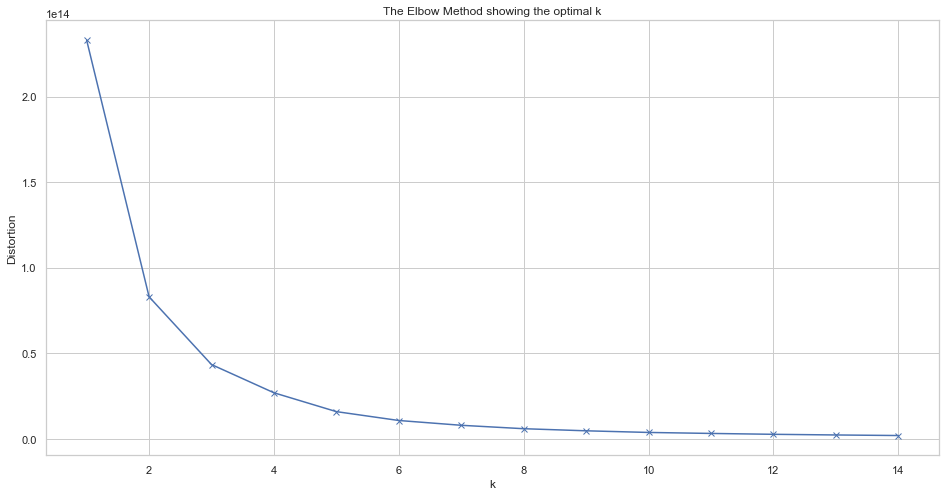

In [564]:
distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(home_grouped_clustering)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [565]:
np.random.seed(0)
# from elbow method, set number of clusters to 6
kclusters = 6

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(home_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 4, 0, 4, 4, 0, 0, 0, 0, 0], dtype=int32)

In [566]:
labels = kmeans.labels_
print(labels)

[0 4 0 4 4 0 0 0 0 0 0 0 0 0 4 4 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 0 4 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 4 4 0 2 4 1 2 0 0 2 2
 2 2 5 4 1 2 2 4 5 4 5 0 4 2 0 4 4 4 0 0 4 4 1 0 2 0 0 4 4 4 1 0 4 2 2 0 4
 0 5 4 0 0 0 4 2 2 0 2 4 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 2 4 0 0 4 0 0 0 0 0 0 0 0 4 0 0 2 0 0 0 0 4 4 0 4 4 0 4 0 4 0 0 0
 0 4 1 5 2 2 4 4 4 2 4 4 2 4 2 5 2 0 4 4 0 2 1 4 4 0 2 2 0 4 0 2 2 4 2 1 1
 4 0 0 0 4 0 4 2 2 2 4 2 1 2 0 0 0 3 1 0 0 0 0 0 0 0 4 0 4 0 0 0 4 4 4 0 0
 0 4 4 4 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 2 2 4 4 4 0 4 2 2 2
 4 4 5 2 2 5 2 2 4 2 0 0 4 4 4 4 4 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0
 4 0 0 0 4 0 4 4 4 2 2 4 4 2 4 4 0 4 0 4 4 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 0
 4 0 4 4 0 4 0 0 4 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 4 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 0 4 0 0 4 4 4 4 4 4 4 0
 0 4 0 0 4 4 5 2 5 1 2 1 2 1 2 2 2 2 5 5 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 4 0 0 0 0 0 4 0 0 0 4 0 

In [569]:
#Create a column called Labels and attach the respective label of each row
home_grouped['Labels'] = labels
home_grouped.head()

,street,zipcode,bathrooms,bedrooms,description,latitude,sqft,longitude,price,url,yearBuilt,neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,African Restaurant,American Restaurant,Antique Shop,Arcade,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Beach,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Building,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Campground,Candy Store,Caribbean Restaurant,Carpet Store,Casino,Cemetery,Chinese Restaurant,Chiropractor,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,Comedy Club,Comfort Food Restaurant,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Cuban Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Drugstore,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Eye Doctor,Fabric Shop,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Frame Store,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hospital,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts School,Massage Studio,Medical Center,Medical Supply Store,Mediterranean Restaurant,Memorial Site,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Motorcycle Shop,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Nightlife Spot,Non-Profit,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Repair Shop,Outdoor Supply Store,Outdoors & Recreation,Paintball Field,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Pet Café,Pet Store,Pharmacy,Photography Studio,Pie Shop,Pier,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Pool,Pop-Up Shop,Print Shop,Pub,Public Art,Racetrack,Ramen Restaurant,Record Shop,Recording Studio,Rental Car Location,Rest Area,Restaurant,River,Road,Rock Club,Roof Deck,Rugby Pitch,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,School,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Ski Area,Smoke Shop,Snack Place,Soccer Field,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Spiritual Center,Sporting Goods Shop,Sports Bar,Sports Club,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Surf Spot,Sushi Restaurant,Szechuan Restaurant,Taco Place,Tailor Shop,Tapas 

In [621]:
map_clusters_home = folium.Map(location=[latitude, longitude], zoom_start=11.6)

mn_geo = r'Minneapolis_Neighborhoods.geojson'

map_clusters_home.choropleth(geo_data = mn_geo, 
              data = neighborhoodVenues,
              columns = ['neighborhood', 'count'],
              key_on = 'feature.properties.name',
              fill_color =  'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.4,
              highlight=True,
              legend_name = 'Strength of neighborhood venues',
              reset=True)


folium.LayerControl().add_to(map_clusters_home)

# uncomment this to get pop ups of each neighborhood as well
# add markers to map
for lat, lng, neighborhood in zip(neighborhoodMinn['latitude'], neighborhoodMinn['longitude'], neighborhoodMinn['neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.Marker(
        [lat, lng],
        popup=label).add_to(map_clusters_home) 

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(home_grouped['latitude'], home_grouped['longitude'], home_grouped['zipcode'], home_grouped['Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_home)
       

               
map_clusters_home

<ul>
<li>Cluster 0: Red
<li>Cluster 4: Light Green
<li>Cluster 2: Blue
<li>Cluster 1: Purple
<li>Cluster 5: Orange 
<li>Cluster 3: Turqoise (only two homes)
</ul>


In [642]:
#0

homeCluster0 = home_grouped.loc[home_grouped['Labels'] == 0, list(home_grouped.columns[2:12])]
homeCluster0.drop(homeCluster0.columns[[2, 3, 5, 7]], axis = 1, inplace = True)
#homeCluster0

In [641]:
#4

homeCluster4 = home_grouped.loc[home_grouped['Labels'] == 4, list(home_grouped.columns[2:12])]
homeCluster4.drop(homeCluster4.columns[[2, 3, 5, 7]], axis = 1, inplace = True)
#homeCluster4

In [640]:
#2

homeCluster2 = home_grouped.loc[home_grouped['Labels'] == 2, list(home_grouped.columns[2:12])]
homeCluster2.drop(homeCluster2.columns[[2, 3, 5, 7]], axis = 1, inplace = True)
#homeCluster2

In [639]:
#1

homeCluster1 = home_grouped.loc[home_grouped['Labels'] == 1, list(home_grouped.columns[2:12])]
homeCluster1.drop(homeCluster1.columns[[2, 3, 5, 7]], axis = 1, inplace = True)
#homeCluster1

In [638]:
#3

homeCluster3 = home_grouped.loc[home_grouped['Labels'] == 3, list(home_grouped.columns[2:12])]
homeCluster3.drop(homeCluster3.columns[[2, 3, 5, 7]], axis = 1, inplace = True)
homeCluster3

,bathrooms,bedrooms,sqft,price,yearBuilt,neighborhood
249,8,5,7301,4900000,1911,"East Isles, Minneapolis"
576,11,10,14399,5995000,1903,"Lowry Hill, Minneapolis"


In [583]:
finaldf = home_grouped.groupby('Labels').mean()
finaldf = finaldf.loc[:,finaldf.columns[[1, 2, 4, 6, 7]]]
finaldf.sort_values('price')

,bathrooms,bedrooms,sqft,price,yearBuilt
Labels,,,,,
0,1.642715,2.854291,1427.409182,2.594038e+05,1932.718563
4,2.679558,3.591160,2298.414365,5.337172e+05,1944.939227
2,3.814815,4.098765,3460.197531,9.945210e+05,1952.283951
1,4.708333,4.166667,4837.416667,1.817612e+06,1949.125000
5,4.571429,4.214286,5336.785714,2.930350e+06,1953.285714
3,9.500000,7.500000,10850.000000,5.447500e+06,1907.000000


In [582]:
home_grouped["Labels"].value_counts()

0    501
4    181
2     81
1     24
5     14
3      2
Name: Labels, dtype: int64

In [606]:
neighborhoodCompare = home_grouped.groupby('neighborhood').mean()
neighborhoodCompare = neighborhoodCompare.loc[:,neighborhoodCompare.columns[[1, 2, 4, 6, 7]]]
#Ordered by ascending neighborhood average home sale price
neighborhoodCompare.sort_values(['price'])

,bathrooms,bedrooms,sqft,price,yearBuilt
neighborhood,,,,,
"Folwell, Minneapolis",1.611111,2.833333,1425.833333,1.833404e+05,1923.055556
"East Phillips, Minneapolis",1.600000,2.400000,1265.000000,1.919200e+05,1959.800000
"Hawthorne, Minneapolis",2.000000,3.818182,1764.454545,1.952414e+05,1923.181818
"Cleveland, Minneapolis",1.583333,3.000000,1421.666667,1.973110e+05,1924.500000
"Jordan, Minneapolis",1.847826,3.478261,1549.021739,2.032836e+05,1926.543478
"Webber-Camden, Minneapolis",1.571429,3.214286,1466.714286,2.134706e+05,1919.928571
"Lind-Bohanon, Minneapolis",1.857143,3.071429,1814.571429,2.335137e+05,1958.714286
"Victory, Minneapolis",1.800000,3.100000,1696.600000,2.424119e+05,1931.800000
"Shingle Creek, Minneapolis",2.000000,2.800000,1826.100000,2.470414e+05,1970.600000


#### Visualizations for better understanding of our clusters

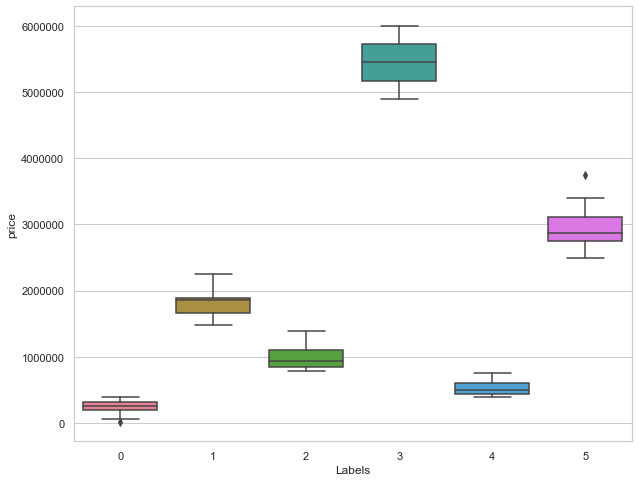

In [587]:
import seaborn as sns
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.boxplot(x="Labels", y="price", ax = ax, data=home_grouped)

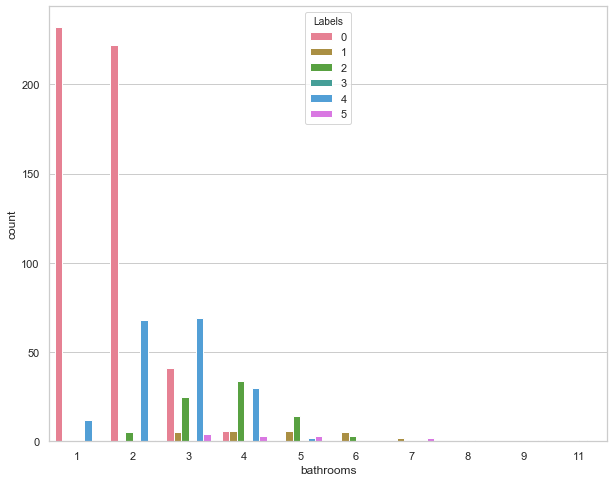

In [589]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x="bathrooms", hue="Labels", data=home_grouped, ax = ax)

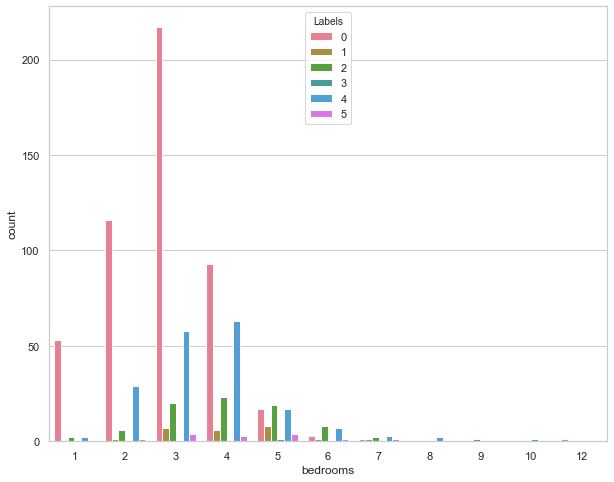

In [590]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.countplot(x="bedrooms", hue="Labels", data=home_grouped, ax = ax)

In [644]:
home_grouped.corr()['price'].sort_values()

longitude                         -0.229087
zipcode                           -0.167247
Convenience Store                 -0.115296
Discount Store                    -0.115137
Grocery Store                     -0.110741
Liquor Store                      -0.105798
Fast Food Restaurant              -0.104799
BBQ Joint                         -0.104061
Food & Drink Shop                 -0.103769
Restaurant                        -0.102410
latitude                          -0.098972
Chinese Restaurant                -0.087503
Food Truck                        -0.078126
Music Store                       -0.075276
Mexican Restaurant                -0.069319
Shoe Store                        -0.069269
Business Service                  -0.066810
Bus Station                       -0.066357
Ramen Restaurant                  -0.063500
Asian Restaurant                  -0.063299
Burger Joint                      -0.063128
ATM                               -0.063113
Home Service                    

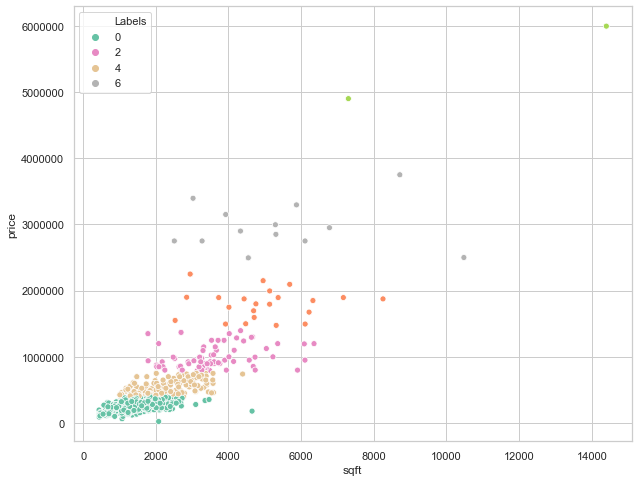

In [643]:
fig_dims = (10, 8)
fig, ax = plt.subplots(figsize=fig_dims)
sns.scatterplot(x = "sqft", y = "price", ax = ax, data = home_grouped, hue = "Labels", palette= "Set2")

[Text(0, 0, 'Armatage, Minneapolis'),
 Text(0, 0, 'Audubon Park, Minneapolis'),
 Text(0, 0, 'Bancroft, Minneapolis'),
 Text(0, 0, 'Beltrami, Minneapolis'),
 Text(0, 0, 'Bottineau, Minneapolis'),
 Text(0, 0, 'Bryant, Minneapolis'),
 Text(0, 0, 'Bryn Mawr, Minneapolis'),
 Text(0, 0, 'Cedar-Isles-Dean, Minneapolis'),
 Text(0, 0, 'Cedar-Riverside, Minneapolis'),
 Text(0, 0, 'Central, Minneapolis'),
 Text(0, 0, 'Cleveland, Minneapolis'),
 Text(0, 0, 'Columbia Park, Minneapolis'),
 Text(0, 0, 'Cooper, Minneapolis'),
 Text(0, 0, 'Corcoran, Minneapolis'),
 Text(0, 0, 'Diamond Lake, Minneapolis'),
 Text(0, 0, 'Downtown East, Minneapolis'),
 Text(0, 0, 'East Calhoun, Minneapolis'),
 Text(0, 0, 'East Harriet, Minneapolis'),
 Text(0, 0, 'East Isles, Minneapolis'),
 Text(0, 0, 'East Phillips, Minneapolis'),
 Text(0, 0, 'Ericsson, Minneapolis'),
 Text(0, 0, 'Field, Minneapolis'),
 Text(0, 0, 'Folwell, Minneapolis'),
 Text(0, 0, 'Fulton, Minneapolis'),
 Text(0, 0, 'Hale, Minneapolis'),
 Text(0, 0, 'H

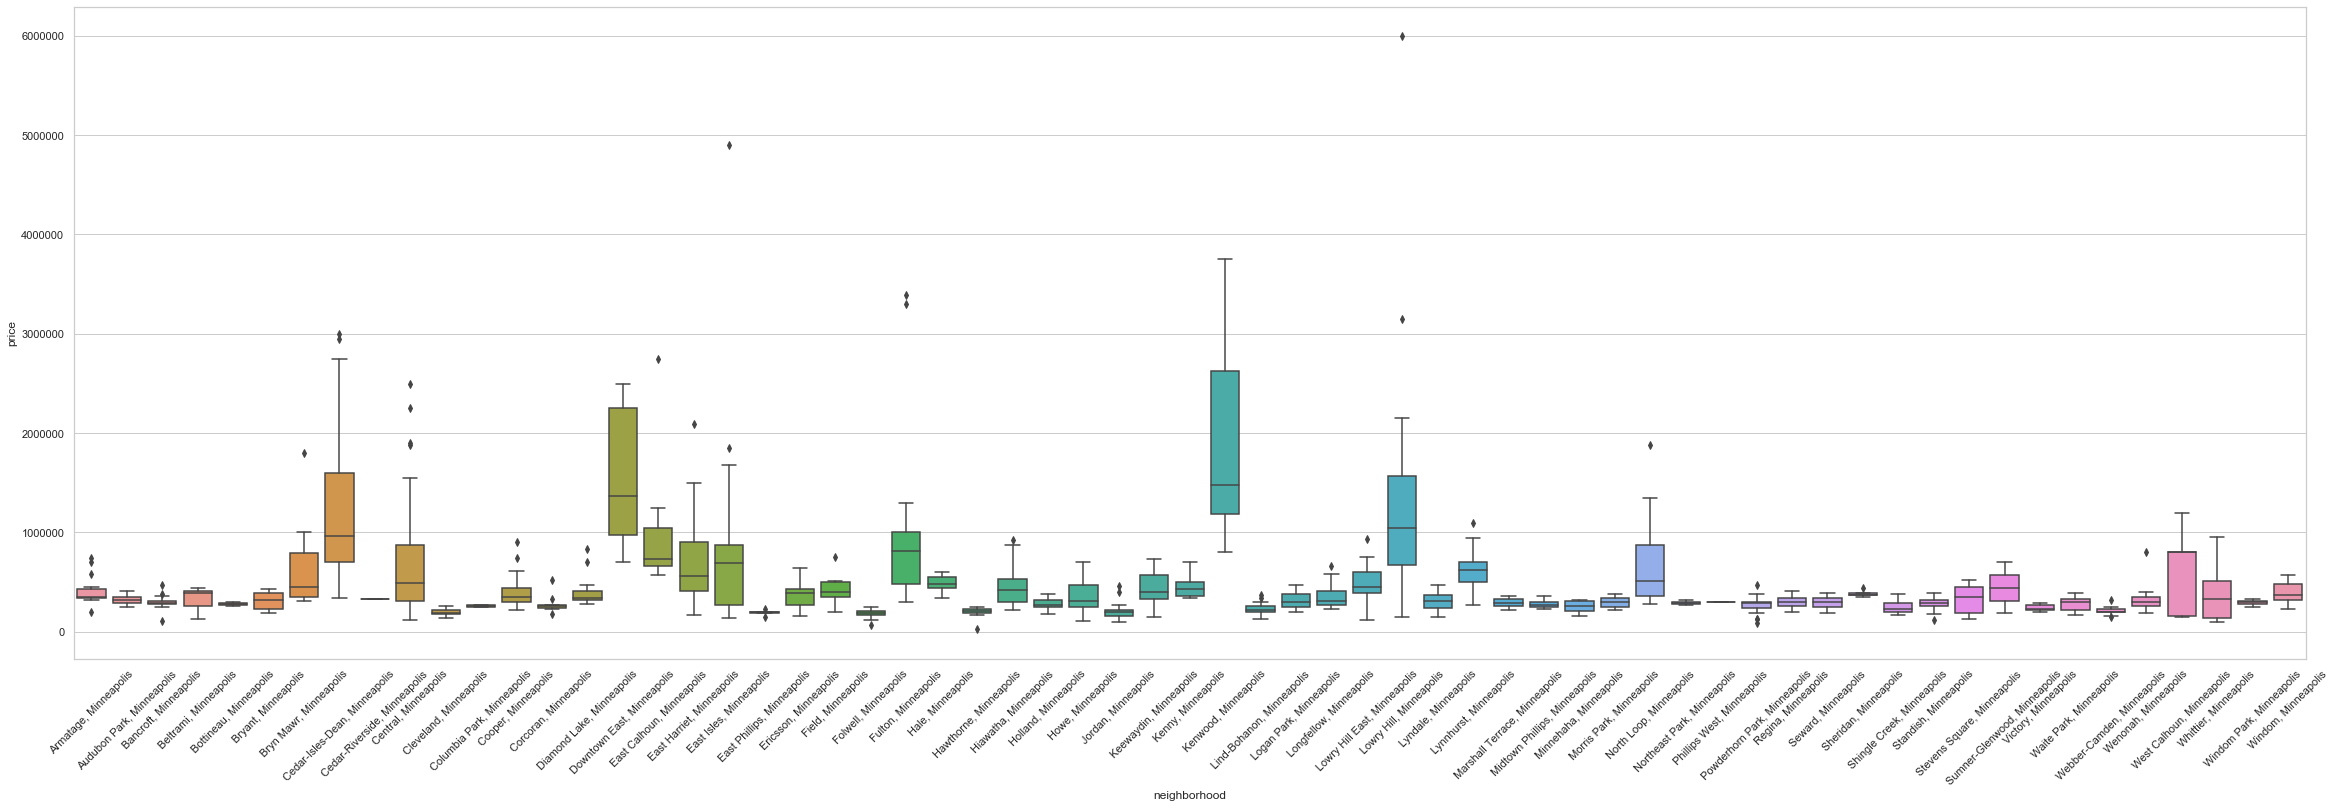

In [605]:
fig_dims = (40, 12)
fig, ax = plt.subplots(figsize=fig_dims)
chart = sns.boxplot(x="neighborhood", y="price", ax = ax, data=home_grouped)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)